# RNN for time-series

In [1]:
# Put these at the top of every notebook, to get automatic reloading and inline plotting
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.column_data import *
from fastai.text import *

## Generate some data

In [3]:
N  = 30000 # Number of samples
b, c, tau = 0.1, 0.2, 17
y = [0.9697, 0.9699, 0.9794, 1.0003, 1.0319, 1.0703, 1.1076, 1.1352, 1.1485,
     1.1482, 1.1383, 1.1234, 1.1072, 1.0928, 1.0820, 1.0756, 1.0739, 1.0759]
for n in range(17,N+99):
    y.append(y[n] - b*y[n] + c*y[n-tau]/(1+y[n-tau]**10))
x = np.array(y[100:])
n = np.array(list(range(len(x)))) # n is just for testing purposes

In [4]:
path = 'data/'

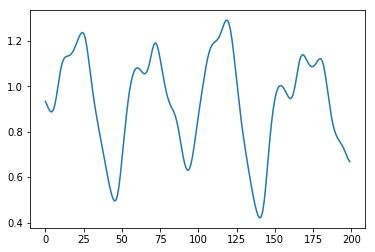

In [5]:
plt.plot(x[:200]);

## Create sequences

In [6]:
seq_len = 3
xs = x.reshape(-1,seq_len)
ns = n.reshape(-1,seq_len)
xs.shape, ns.shape

((10000, 3), (10000, 3))

In [7]:
ys, yn = xs[1:,0].reshape(-1,1), ns[1:,0].reshape(-1,1)
xs, ns = xs[:-1,:], ns[:-1,:]
ns[:10, :], yn[:10]

(array([[ 0,  1,  2],
        [ 3,  4,  5],
        [ 6,  7,  8],
        [ 9, 10, 11],
        [12, 13, 14],
        [15, 16, 17],
        [18, 19, 20],
        [21, 22, 23],
        [24, 25, 26],
        [27, 28, 29]]), array([[ 3],
        [ 6],
        [ 9],
        [12],
        [15],
        [18],
        [21],
        [24],
        [27],
        [30]]))

For each sequence we want to predict the next value, for example, the first line is $[0, 1, 2, 3]$ and we want to predict $[4]$. We will use $xs$ and $ys$, $ns$ and $yn$ are just to check if the sequences are created as we expect.

In [8]:
# Last 30% of data for validation
val_idx = np.arange(len(xs)//(1/0.7), len(xs)).astype(int);
len(val_idx)/len(xs)

0.3000300030003

## Define and train the model

In [9]:
# Based on Lesson 6 Char3Model (http://course.fast.ai/lessons/lesson6.html @1:33:18)
class TSRnn3steps(nn.Module):
    def __init__(self, in_sz, h_sz, out_sz):
        super().__init__()
        self.lin_in = nn.Linear(in_sz, h_sz)
        self.lin_h = nn.Linear(h_sz, h_sz)
        self.lin_out = nn.Linear(h_sz, out_sz)
    
    def forward(self, x1, x2, x3):
        x1 = F.relu(self.lin_in(x1.view(-1,1)))
        x2 = F.relu(self.lin_in(x2.view(-1,1)))
        x3 = F.relu(self.lin_in(x3.view(-1,1)))
        
        h = torch.zeros(x1.size(), requires_grad=True).cuda()
        h = F.tanh(self.lin_h(x1))
        h = F.tanh(self.lin_h(h+x2))
        h = F.tanh(self.lin_h(h+x3))
        
        return self.lin_out(h)

In [10]:
md = ColumnarModelData.from_arrays(path, val_idx, xs.astype(float), ys.astype(float), bs=100)

In [11]:
# https://github.com/fastai/fastai/blob/master/courses/dl2/translate.ipynb
m = RNN_Learner(md, SingleModel(to_gpu(TSRnn3steps(1,10,1))))
m.crit = nn.L1Loss()

In [12]:
m.lr_find()

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

 87%|████████▋ | 61/70 [00:00<00:00, 590.10it/s, loss=0.681]


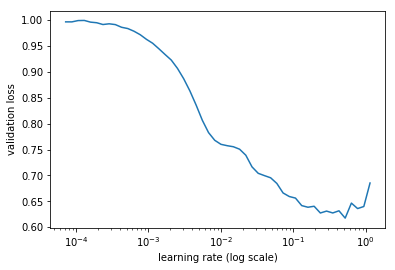

In [13]:
m.sched.plot()

In [14]:
lr = 1e-1
m.fit(lr, 1, cycle_len=12, use_clr=(20,10))

HBox(children=(IntProgress(value=0, description='Epoch', max=12), HTML(value='')))

epoch      trn_loss   val_loss                              
    0      0.147627   0.051404  
    1      0.137927   0.036533                              
    2      0.098671   0.060815                               
    3      0.084149   0.101479                               
    4      0.069266   0.138042                               
    5      0.04473    0.024906                               
    6      0.045342   0.009957                              
    7      0.036147   0.040656                               
    8      0.040032   0.011752                               
    9      0.02264    0.013632                               
    10     0.01219    0.006895                               
    11     0.007746   0.005761                                



[0.005761212824533383]

## Multi-step predictions

In [15]:
# Generate test data
N  = 103 # Number of samples
b, c, tau = 0.1, 0.2, 17
y = [0.9697, 0.9699, 0.9794, 1.0003, 1.0319, 1.0703, 1.1076, 1.1352, 1.1485,
     1.1482, 1.1383, 1.1234, 1.1072, 1.0928, 1.0820, 1.0756, 1.0739, 1.0759]
y = list(np.random.permutation(y))
for n in range(17,N+99):
    y.append(y[n] - b*y[n] + c*y[n-tau]/(1+y[n-tau]**10))
x = np.array(y[100:])

In [16]:
in_test = [T(o) for o in x[:3]]
out_save = []
while len(out_save) < N:
    out = m.model(*in_test)
    in_test = [*in_test, out[0]][1:]
    out_save.append(out.item())

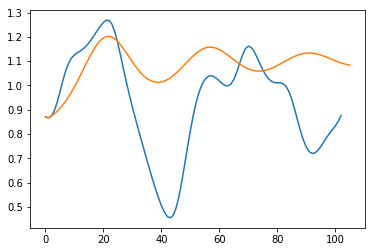

In [17]:
plt.plot(x)
plt.plot([*x[:3], *out_save])